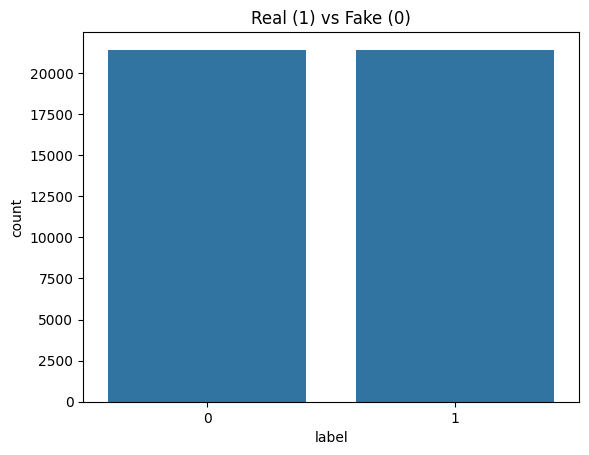

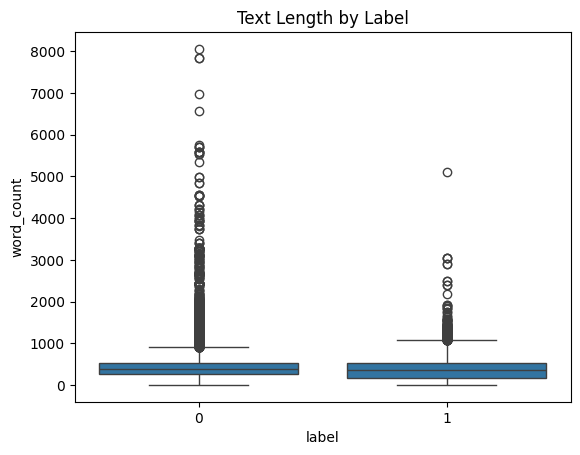

Batches:   0%|          | 0/857 [00:00<?, ?it/s]

Batches:   0%|          | 0/215 [00:00<?, ?it/s]

Batches:   0%|          | 0/268 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 13707, number of negative: 13706
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97920
[LightGBM] [Info] Number of data points in the train set: 27413, number of used features: 384
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500018 -> initscore=0.000073
[LightGBM] [Info] Start training from score 0.000073

Model: Logistic Regression (Val)

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3427
           1       0.95      0.96      0.96      3427

    accuracy                           0.96      6854
   macro avg       0.96      0.96      0.96      6854
weighted avg       0.96      0.96      0.96      6854



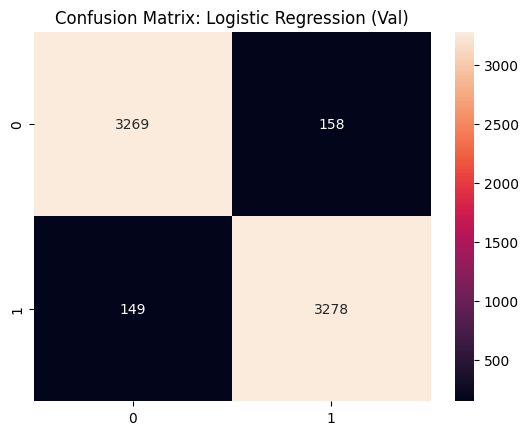


Model: Random Forest (Val)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3427
           1       0.95      0.95      0.95      3427

    accuracy                           0.95      6854
   macro avg       0.95      0.95      0.95      6854
weighted avg       0.95      0.95      0.95      6854



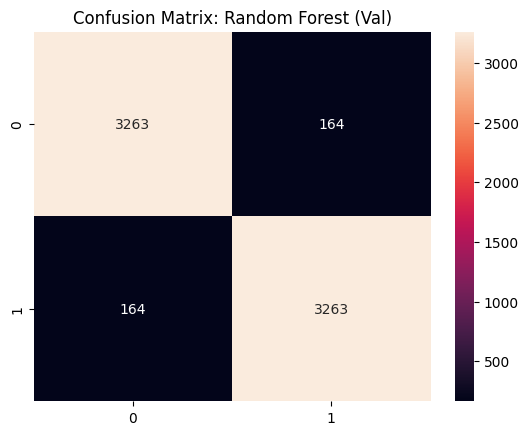


Model: XGBoost (Val)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3427
           1       0.97      0.97      0.97      3427

    accuracy                           0.97      6854
   macro avg       0.97      0.97      0.97      6854
weighted avg       0.97      0.97      0.97      6854



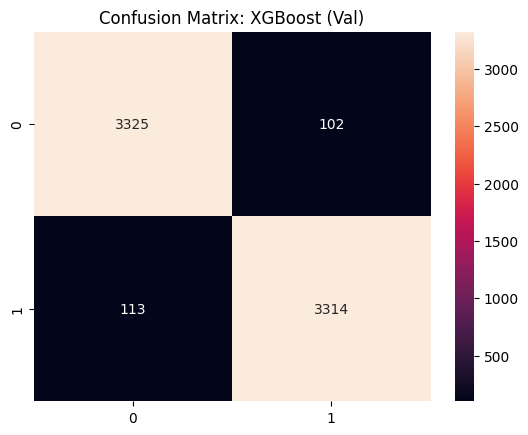


Model: LightGBM (Val)

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      3427
           1       0.96      0.95      0.95      3427

    accuracy                           0.95      6854
   macro avg       0.95      0.95      0.95      6854
weighted avg       0.95      0.95      0.95      6854



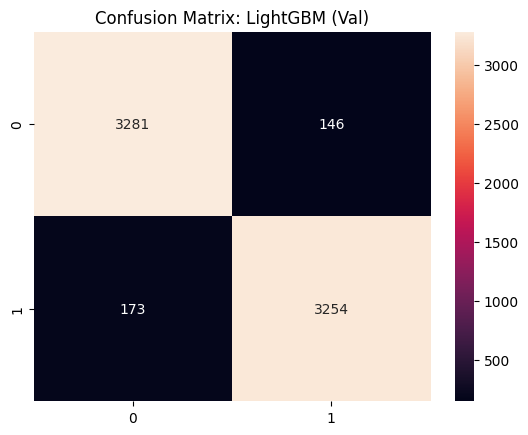


Model: Logistic Regression (Test)

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      4284
           1       0.95      0.96      0.95      4283

    accuracy                           0.95      8567
   macro avg       0.95      0.95      0.95      8567
weighted avg       0.95      0.95      0.95      8567



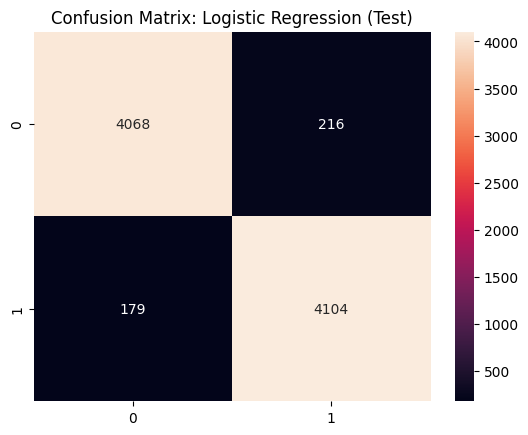


Model: Random Forest (Test)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4284
           1       0.95      0.95      0.95      4283

    accuracy                           0.95      8567
   macro avg       0.95      0.95      0.95      8567
weighted avg       0.95      0.95      0.95      8567



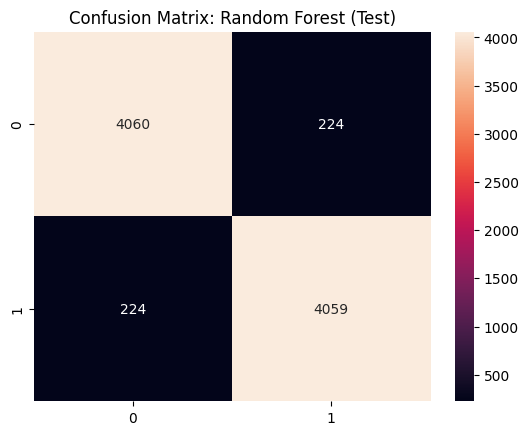


Model: XGBoost (Test)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4284
           1       0.96      0.97      0.97      4283

    accuracy                           0.97      8567
   macro avg       0.97      0.97      0.97      8567
weighted avg       0.97      0.97      0.97      8567



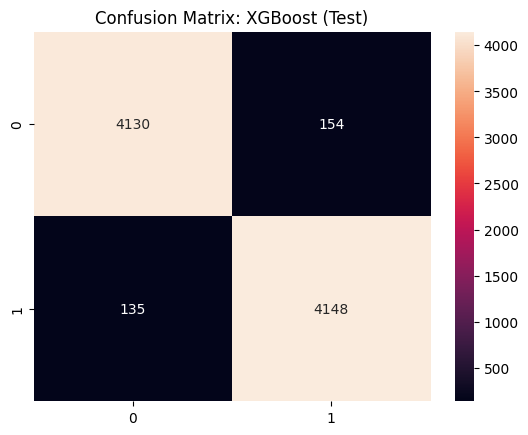


Model: LightGBM (Test)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4284
           1       0.95      0.95      0.95      4283

    accuracy                           0.95      8567
   macro avg       0.95      0.95      0.95      8567
weighted avg       0.95      0.95      0.95      8567



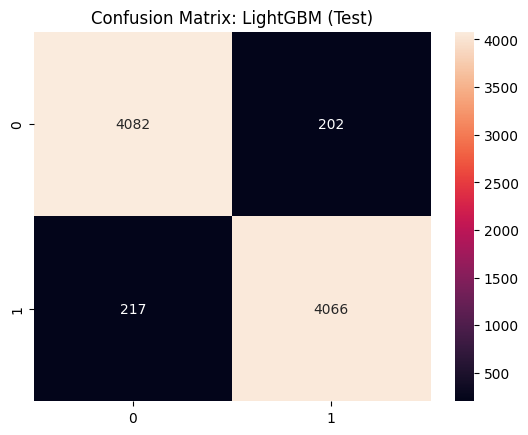


News: Transgender individuals will be allowed for the first time to enlist in the U.S. military starting Monday.
Confidence (FAKE, REAL): [0.4816656 0.5183344]
Prediction: REAL


In [7]:

#  FAKE NEWS PREDICTION 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')


fake = pd.read_csv("Fake.csv")
real = pd.read_csv("True.csv")
fake['label'] = 0
real['label'] = 1

df = pd.concat([fake, real], ignore_index=True).sample(frac=1, random_state=42)
df['text'] = df['title'] + " " + df['text']
df = df[['text', 'label']]


def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"[^a-zA-Z ]", '', text)
    text = re.sub(r"\s+", ' ', text).strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))


fake = df[df['label'] == 0]
real = df[df['label'] == 1]
min_len = min(len(fake), len(real))
fake_balanced = resample(fake, n_samples=min_len, random_state=42)
real_balanced = resample(real, n_samples=min_len, random_state=42)
df_balanced = pd.concat([fake_balanced, real_balanced]).sample(frac=1, random_state=42).reset_index(drop=True)


sns.countplot(x='label', data=df_balanced)
plt.title("Real (1) vs Fake (0)")
plt.show()

sns.boxplot(x='label', y='word_count', data=df_balanced)
plt.title("Text Length by Label")
plt.show()

WordCloud(width=800, height=400).generate(" ".join(df_balanced[df_balanced.label==0]['clean_text'])).to_image()
WordCloud(width=800, height=400).generate(" ".join(df_balanced[df_balanced.label==1]['clean_text'])).to_image()


X = df_balanced['clean_text']
y = df_balanced['label']
X_temp, X_test_raw, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)


model_bert = SentenceTransformer('all-MiniLM-L6-v2')
X_train = model_bert.encode(X_train_raw.tolist(), show_progress_bar=True)
X_val = model_bert.encode(X_val_raw.tolist(), show_progress_bar=True)
X_test = model_bert.encode(X_test_raw.tolist(), show_progress_bar=True)


logreg = LogisticRegression()
gs_logreg = GridSearchCV(logreg, {"C": [0.1, 1, 10]}, cv=3)
gs_logreg.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

lgb = LGBMClassifier()
lgb.fit(X_train, y_train)

def evaluate_model(name, model, X_eval, y_eval):
    y_pred = model.predict(X_eval)
    print(f"\nModel: {name}\n")
    print(classification_report(y_eval, y_pred))
    sns.heatmap(confusion_matrix(y_eval, y_pred), annot=True, fmt='d')
    plt.title(f"Confusion Matrix: {name}")
    plt.show()


evaluate_model("Logistic Regression (Val)", gs_logreg.best_estimator_, X_val, y_val)
evaluate_model("Random Forest (Val)", rf, X_val, y_val)
evaluate_model("XGBoost (Val)", xgb, X_val, y_val)
evaluate_model("LightGBM (Val)", lgb, X_val, y_val)


evaluate_model("Logistic Regression (Test)", gs_logreg.best_estimator_, X_test, y_test)
evaluate_model("Random Forest (Test)", rf, X_test, y_test)
evaluate_model("XGBoost (Test)", xgb, X_test, y_test)
evaluate_model("LightGBM (Test)", lgb, X_test, y_test)


def predict_news(text, model):
    cleaned = clean_text(text)
    embedded = model_bert.encode([cleaned])
    proba = model.predict_proba(embedded)[0]
    print("Confidence (FAKE, REAL):", proba)
    return "REAL" if proba[1] >= 0.5 else "FAKE"


final_model = xgb
sample = "Transgender individuals will be allowed for the first time to enlist in the U.S. military starting Monday."
print("\nNews:", sample)
print("Prediction:", predict_news(sample, final_model))


In [8]:
sample = "BREAKING: Obama caught hiding aliens in the White House basement!"
print("\nNews: ", sample)
print("Prediction: ", predict_news(sample, final_model))



News:  BREAKING: Obama caught hiding aliens in the White House basement!
Confidence (FAKE, REAL): [9.993144e-01 6.855835e-04]
Prediction:  FAKE


In [9]:
sample = "As U.S. budget fight looms, Republicans flip their fiscal script. The Republican Party is embracing deeper deficits."
print("Prediction:", predict_news(sample, final_model))


Confidence (FAKE, REAL): [0.4346782 0.5653218]
Prediction: REAL


In [10]:
import joblib
joblib.dump(final_model, "Fake news prediction final.pkl")


['Fake news prediction final.pkl']